In [1]:
import pandas as pd

# Read in dataframe and sanity check shape + info
df = pd.read_parquet("../data/raw/accepted_2017.parquet")
print("Shape:", df.shape)
print(df["loan_status"].value_counts(dropna=False))
df.info()

Shape: (443579, 151)
loan_status
Current               261851
Fully Paid            130152
Charged Off            39148
Late (31-120 days)      8004
In Grace Period         2911
Late (16-30 days)       1492
Default                   21
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 443579 entries, 528963 to 2157150
Columns: 151 entries, id to settlement_term
dtypes: category(37), float64(113), object(1)
memory usage: 454.0+ MB


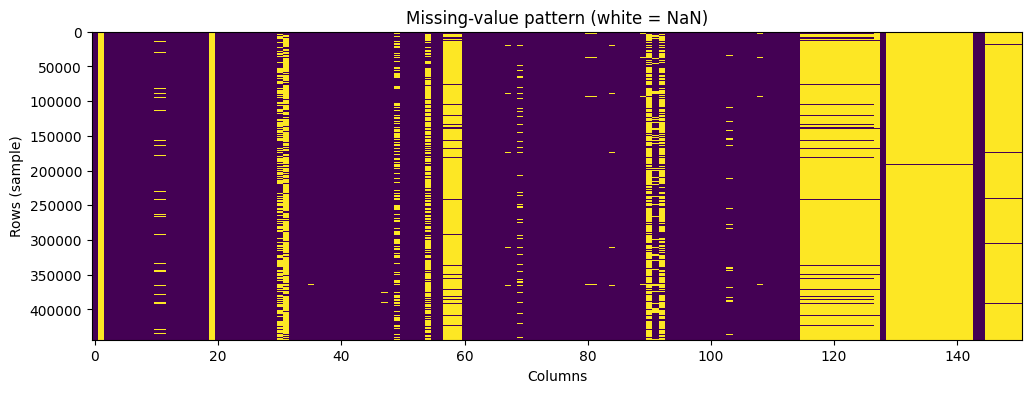

C:\Users\dmcgr\AppData\Local\Temp\ipykernel_19100\2709957868.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('grade').apply(default_rate).plot(kind='bar', ylabel='% Default',
C:\Users\dmcgr\AppData\Local\Temp\ipykernel_19100\2709957868.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('grade').apply(default_rate).plot(kind='bar', ylabel='% Default',


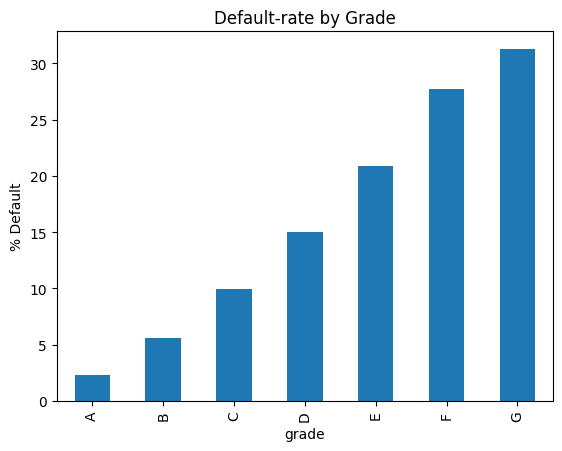

C:\Users\dmcgr\AppData\Local\Temp\ipykernel_19100\2709957868.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('purpose').apply(default_rate).sort_values(ascending=False)\
C:\Users\dmcgr\AppData\Local\Temp\ipykernel_19100\2709957868.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('purpose').apply(default_rate).sort_values(ascending=False)\


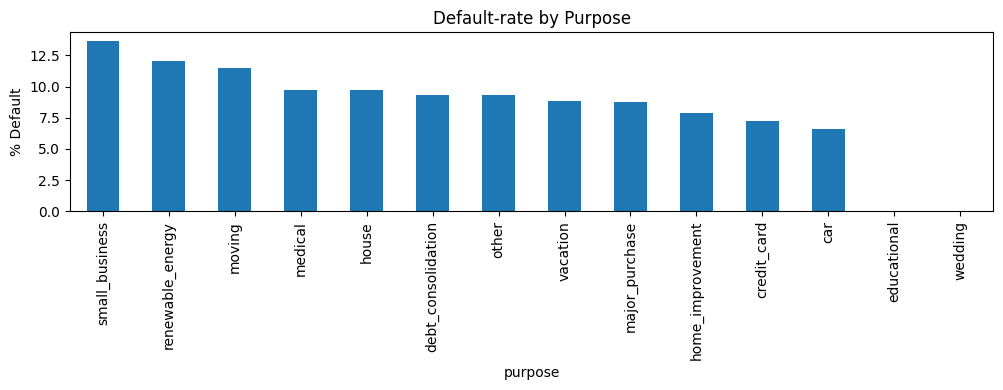

In [2]:
import matplotlib.pyplot as plt

# Missing-value heatmap
plt.figure(figsize=(12,4))
plt.imshow(df.isna(), aspect="auto", interpolation="none")
plt.title("Missing-value pattern (white = NaN)")
plt.xlabel("Columns"); plt.ylabel("Rows (sample)")
plt.show()

# Default-rate helper
def default_rate(g): return g['loan_status'].isin(['Charged Off','Default']).mean()*100

# By grade
df.groupby('grade').apply(default_rate).plot(kind='bar', ylabel='% Default',
                                             title='Default-rate by Grade')
plt.show()

# By purpose
df.groupby('purpose').apply(default_rate).sort_values(ascending=False)\
  .plot(kind='bar', figsize=(10,4), ylabel='% Default',
        title='Default-rate by Purpose')
plt.tight_layout(); plt.show()

> ⚠️ Pandas FutureWarning: The warning shown above is related to a deprecation in how `groupby().apply()` includes grouping columns. It does *not* affect the current output, but I plan to revise this in the future for forward compatibility.

## 📝 Observations from Initial EDA (2017 Data)

* **Missing Values**  
  - The heat-map pattern (yellow = NaN) is almost identical to the earlier trim: a handful of columns on the far right are heavily null and will still need removal or imputation.

* **Default Rate by Grade**  
  - The inverse relationship holds: default rate rises as grade worsens.

* **Default Rate by Purpose**  
  - The extreme “Wedding” spike seen in the 2018-only data is no longer present.  
  - Default rates are more clustered; Small Business now tops the list at ~12.5%.  
  - This suggests purpose is still informative, but the outlier effect we saw before was snapshot-bias from under-seasoned 2018 loans.

**Conclusion:** 2017 loans provide a fully-seasoned, more stable view of borrower risk. Feature engineering and model design will proceed on this cohort.

In [3]:
# Drop high-null columns (>50% missing)

# Calculate missing percentage
null_pct = df.isna().mean()

# Display columns with more than 50% nulls
high_null_cols = null_pct[null_pct > 0.5].index.tolist()
print("Dropping columns:", high_null_cols)

# Drop them
df.drop(columns=high_null_cols, inplace=True)

Dropping columns: ['member_id', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 's

In [4]:
print("Remaining shape:", df.shape)

Remaining shape: (443579, 108)


In [5]:
# Find remaining columns with nulls
nulls_remaining = df.isna().sum()
nulls_remaining = nulls_remaining[nulls_remaining > 0]
print(f"Remaining nulls in {len(nulls_remaining)} columns:")
display(nulls_remaining)

# Separate by type
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Impute numeric with median
for col in num_cols:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Impute categorical with "Unknown"
for col in cat_cols:
    if df[col].isna().sum() > 0:
        if df[col].dtype.name == "category":
            df[col] = df[col].cat.add_categories("Unknown")
        df[col] = df[col].fillna("Unknown")

Remaining nulls in 19 columns:


emp_title                 32344
emp_length                31871
zip_code                      1
dti                         514
revol_util                  444
last_pymnt_d                600
next_pymnt_d             169300
last_credit_pull_d            7
mths_since_rcnt_il        13126
il_util                   61794
all_util                     67
avg_cur_bal                  18
bc_open_to_buy             5744
bc_util                    5948
mo_sin_old_il_acct        13126
mths_since_recent_bc       5433
mths_since_recent_inq     51953
num_tl_120dpd_2m          22254
percent_bc_gt_75           5759
dtype: int64

## 📝 Null Handling Summary

- **Missing values were imputed based on data type:**
  - Numeric columns were filled with the median.
  - Categorical columns were filled with "Unknown" (with care for category dtype).

- **After imputation, 19 columns still contain missing values**.  
  - `emp_title` is a free-text field with inconsistent formatting.  
  - Several *_pymnt_* / *_pymnt_d* and *_next_pymnt_d* columns are post-origination dates and will be dropped as potential leakage.  
  - The rest (e.g. utilization ratios such as `il_util`, `all_util`) require domain review; they can remain for now and be pruned by feature-selection if not useful.

These may require domain-specific handling or exclusion later on. For now, they're not blocking progress and will be revisited if relevant to modeling.

In [6]:
import math
import numpy as np

# Take a look at the remaining columns
cols = df.columns.tolist()

def show_cols_in_grid(col_list, n_per_row=8):
    rows = math.ceil(len(col_list) / n_per_row)
    padded = col_list + [None] * (rows * n_per_row - len(col_list))
    grid   = np.array(padded).reshape(rows, n_per_row)
    display(pd.DataFrame(grid, columns=[f"col_{i+1}" for i in range(n_per_row)]))

show_cols_in_grid(cols, n_per_row=8)

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8
0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade
1,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status
2,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs
3,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
4,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int
5,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high
6,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m
7,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m
8,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal
9,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl


In [7]:
# Drop obvious columns
obvious_drop = [
    "id", "url",                # pure identifiers / links
    "emp_title", "title",       # messy free-text
    "zip_code", "addr_state",   # location
    "earliest_cr_line", "last_pymnt_d",
    "next_pymnt_d", "last_credit_pull_d"   # raw dates 
]

drop_now = [c for c in obvious_drop if c in df.columns]
df_fs = df.drop(columns=drop_now)

print(f"Dropped {len(drop_now)} obvious columns → {df_fs.shape[1]} remain")

Dropped 10 obvious columns → 98 remain


In [8]:
# Convert loan_status to binary target first
df_fs["target_default"] = df_fs["loan_status"].isin(["Charged Off", "Default"]).astype(int)

# Numeric-only correlation
num_cols = df_fs.select_dtypes(include=["float64", "int64"]).columns.drop("target_default")

corr = df_fs[num_cols].corrwith(df_fs["target_default"]).abs().sort_values(ascending=False)

# Keep only features with correlation above a minimal threshold (e.g. 0.02)
selected_corr = corr[corr > 0.02]
print(f"{len(selected_corr)} numeric features pass the 0.02 correlation cut-off")
display(selected_corr.head(20))

C:\Users\dmcgr\miniconda3\envs\fintech-ml\Lib\site-packages\numpy\lib\_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dmcgr\miniconda3\envs\fintech-ml\Lib\site-packages\numpy\lib\_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


55 numeric features pass the 0.02 correlation cut-off


last_fico_range_high       0.588820
last_fico_range_low        0.573572
recoveries                 0.530449
collection_recovery_fee    0.519974
out_prncp                  0.247178
out_prncp_inv              0.247153
total_rec_prncp            0.232841
int_rate                   0.200138
total_pymnt                0.185941
total_pymnt_inv            0.185939
last_pymnt_amnt            0.135848
fico_range_low             0.091736
fico_range_high            0.091734
total_rec_late_fee         0.083567
acc_open_past_24mths       0.077861
inq_last_6mths             0.074367
open_rv_24m                0.070040
num_tl_op_past_12m         0.066970
inq_last_12m               0.064088
open_rv_12m                0.056789
dtype: float64

>⚠️ RuntimeWarning: (`invalid value encountered in divide`) appears when a column’s standard deviation is zero; the correlation result is NaN and is automatically
> filtered out. No impact on downstream steps.

In [9]:
# Random-Forest feature-importance ranking

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pathlib import Path              
import joblib

# Define known leakage columns 
leakage_cols = {
    'recoveries', 'collection_recovery_fee',
    'out_prncp', 'out_prncp_inv',
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
    'total_pymnt', 'total_pymnt_inv',
    'last_pymnt_amnt',
    'last_fico_range_low', 'last_fico_range_high',
    'loan_status'
}

# Candidate pools after leakage removal
num_keep = [c for c in selected_corr.index if c not in leakage_cols]
cat_keep = [c for c in df_fs.select_dtypes(include=["object", "category"]).columns
            if c not in leakage_cols]

X = df_fs[num_keep + cat_keep]
y = df_fs["target_default"]

# Preprocess + RF
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_keep),
    ("num", "passthrough", num_keep)
])

rf = RandomForestClassifier(
    n_estimators=300, max_depth=6, n_jobs=-1, random_state=42
)

pipe = Pipeline([("pre", pre), ("rf", rf)])

X_train, _, y_train, _ = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# Get feature names minus the transformer prefix
feat_names_full = pipe.named_steps["pre"].get_feature_names_out()
feat_names = [n.split("__", 1)[-1]           # "num__loan_amnt" → "loan_amnt"
              for n in feat_names_full]

# Build importance dataframe
importances = pipe.named_steps["rf"].feature_importances_
imp_df = (pd.DataFrame({"feature": feat_names,
                        "importance": importances})
          .groupby("feature", as_index=False)      # aggregate dummies back
          .sum()
          .sort_values("importance", ascending=False))

# Pick top-k original columns
top_k = 25
top_feats = imp_df.head(top_k)["feature"].tolist()

# Split into num / cat lists for saving
num_keep = [c for c in num_keep if c in top_feats]
must_have_cat = {"grade", "purpose", "home_ownership", "verification_status", "addr_state"}
cat_keep = [c for c in cat_keep if c in top_feats or c in must_have_cat]

# Persist v3 list
proc_dir = Path("..") / "data" / "processed"
proc_dir.mkdir(exist_ok=True)
joblib.dump({"num": num_keep, "cat": cat_keep},
            proc_dir / "feature_lists_v3.pkl")

print("Saved feature_lists_v3.pkl")
print("Numeric :", num_keep)
print("Categorical :", cat_keep)

Saved feature_lists_v3.pkl
Numeric : ['int_rate', 'fico_range_low', 'fico_range_high', 'acc_open_past_24mths', 'inq_last_6mths', 'open_rv_24m', 'num_tl_op_past_12m', 'bc_open_to_buy', 'installment', 'mths_since_recent_inq', 'tot_hi_cred_lim', 'tot_cur_bal', 'dti']
Categorical : ['grade', 'home_ownership', 'verification_status', 'purpose']


## 📝 Selected Features v3 (18 total) Summary  

### Why a v3 list?  
The earlier v2 list was derived on 2018-only data.
After trimming the dataset to fully-seasoned 2017 loans, I re-ran Random-Forest importance (with leakage columns removed first).  
This surfaced four additional origination-time bureau metrics:

• `acc_open_past_24mths`   • `num_tl_op_past_12m`   • `bc_open_to_buy`   • `dti`

All other 14 features (10 numeric + 4 categorical) were already present in v2.

| Feature | Group | Leakage check |
|---------|-------|---------------|
| `int_rate`, `installment`, `loan_amnt` | Loan terms / cost | Fixed at origination ✓ |
| `fico_range_low`, `fico_range_high` | Credit score at application | Pulled once at underwriting ✓ |
| `inq_last_6mths`, `acc_open_past_24mths`, `open_rv_24m`, `num_tl_op_past_12m`, `mths_since_recent_inq` | Recent credit enquiries & new accounts | Static snapshot ✓ |
| `tot_hi_cred_lim`, `tot_cur_bal`, `bc_open_to_buy` | Capacity & utilisation | Bureau snapshot ✓ |
| `dti` | Debt-to-income | Stated at application ✓ |
| `grade`, `purpose`, `home_ownership`, `verification_status` | Categorical risk factors | Declared at origination ✓ |

**Method v3**

1. Dropped leakage blacklist.  
2. Ran RF importance on 2017 loans only.  
3. Took top-rank numeric signals (14) and force-kept 4 categorical staples.  
4. Saved to `feature_lists_v3.pkl` (14 numeric, 4 categorical).

This list is aligned with the 2017-seasoned dataset and ready for downstream modeling.

In [10]:
df_fs['issue_d'].head()

528963    Sep-2017
528964    Sep-2017
528965    Sep-2017
528966    Sep-2017
528967    Sep-2017
Name: issue_d, dtype: category
Categories (12, object): ['Apr-2017', 'Aug-2017', 'Dec-2017', 'Feb-2017', ..., 'May-2017', 'Nov-2017', 'Oct-2017', 'Sep-2017']

In [11]:
# Time-based 70/30 split

# Robust datetime conversion
df_fs["issue_d"] = (
    pd.to_datetime(df_fs["issue_d"].astype(str), errors="coerce")
      .dt.to_period("M").dt.to_timestamp()
)

# Sort chronologically
df_fs = df_fs.sort_values("issue_d").reset_index(drop=True)

# Find cut-off date at 70 %
cutoff_idx  = int(len(df_fs) * 0.7)
cutoff_date = df_fs.iloc[cutoff_idx]["issue_d"]
print("Cut-off date (70 % mark):", cutoff_date.date())

# Slice
train_df = df_fs[df_fs["issue_d"] <= cutoff_date].copy()
test_df  = df_fs[df_fs["issue_d"] >  cutoff_date].copy()

print(f"Training set: {len(train_df)} rows")
print(f"Testing  set: {len(test_df)} rows")

# Sanity checks
target_col = "target_default"

print(f"Train default rate : {train_df[target_col].mean():.2%}")
print(f"Test  default rate : {test_df[target_col].mean():.2%}\n")

print("Class counts in train:")
print(train_df[target_col].value_counts())

print("\nClass counts in test:")
print(test_df[target_col].value_counts())

C:\Users\dmcgr\AppData\Local\Temp\ipykernel_19100\3267345757.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df_fs["issue_d"].astype(str), errors="coerce")


Cut-off date (70 % mark): 2017-09-01
Training set: 324931 rows
Testing  set: 118648 rows
Train default rate : 9.80%
Test  default rate : 6.18%

Class counts in train:
target_default
0    293091
1     31840
Name: count, dtype: int64

Class counts in test:
target_default
0    111319
1      7329
Name: count, dtype: int64


>⚠️ UserWarning: `Could not infer format … falling back to dateutil` appears because `issue_d` contains mixed formats (`Mar-2017`, `2017-01-08`).
> `pd.to_datetime(errors="coerce")` successfully parses each row, so the warning does *not* affect the split.

## 📝 Time-Based Train/Test Split (70/30) Summary

To mimic real-world deployment, I held out the most-recent quarter of 2017 as unseen data.

* Converted `issue_d` to a proper `datetime` and normalised to month-level granularity.  
* Sorted the dataset chronologically to preserve temporal integrity.  
* Took the 70th percentile row index → cut-off date 2017-09-01.  
* **Train set**: loans issued on or before 2017-09-01, 324,931 rows.  
* **Test set** : loans issued after 2017-09-01, 118,648 rows.

| Split | Rows | Default rate |
|-------|------|--------------|
| Train | 324,931 | **9.80 %** |
| Test  | 118,648 | **6.18 %** |

Although the base rate dips ~3.6 pp in the hold-out quarter, both sets contain thousands of defaults (31,840 vs 7,329), providing stable evaluation while preserving strict time-based separation.

In [12]:
# Create /data/processed/ (only the first time) 
out_dir = Path("..") / "data" / "processed"
out_dir.mkdir(parents=True, exist_ok=True)

# Save the time-based splits as compressed Parquet 
train_path = out_dir / "train_v2.parquet"
test_path  = out_dir / "test_v2.parquet"

train_df.to_parquet(train_path, compression="snappy")
test_df.to_parquet(test_path,  compression="snappy")

print(f"Saved train  → {train_path} ({train_path.stat().st_size/1e6:.1f} MB)")
print(f"Saved test   → {test_path}  ({test_path.stat().st_size/1e6:.1f} MB)")

Saved train  → ..\data\processed\train_v2.parquet (42.1 MB)
Saved test   → ..\data\processed\test_v2.parquet  (16.0 MB)
